# South African Languages Detection Model

South Africa is a multiculatural society. In this classification task, my model will seek to predict the language of a given text among all the South African languages provided. 

The data is from the NCHLT Text Corpora collected by the South African Department of Arts and Culture & Centre for Text Technology (CTexT, North-West University, South Africa).

This model will be submitted to Kaggle as part of a Classification Hackathon organized by the Explore Data Science Academy (EDSA). EDSA trains data scientists and data engineers for the African continent. 

# Importing The Required Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix


# Importing The Data set

The train and test data sets were provided on Kaggle and downloaded to my device. 

In [39]:
train_df = pd.read_csv('train_set.csv')
test_df = pd.read_csv('test_set.csv')

Let's see the contents of the data sets

In [40]:
train_df.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [41]:
train_df.shape

(33000, 2)

We can see that the train data set contains the labels, lang_id, and the text to predict, the text column. There are 33,000 data points in the data set. 

In [42]:
test_df.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [43]:
test_df.shape

(5682, 2)

The test data set contains two columns. The index column and the text column. Later, the index column will be made the index of the data frame while we will use the text column to predict the South African language. This test data set will be treated as the unseen data for the model. 

Next, we will seek to find out the frequency counts of the languages in the training data set. This will give us an idea of the languages that are contained in the data set. 

In [44]:
train_df['lang_id'].unique()

array(['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso',
       'sot', 'afr'], dtype=object)

The code above shows that there are 11 languages in the data set

<AxesSubplot:>

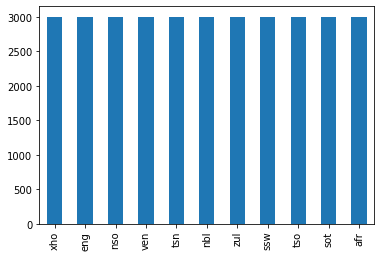

In [45]:
train_df['lang_id'].value_counts().plot(kind='bar')

In [46]:
train_df['lang_id'].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

We can see fom the image above and the non-graphical output that we have a balanced data set. All the languages have 3000 data points. The languages are the classes. 

# Text Preprocessing or Data Cleaning

We will clean the data to remove unwanted features in the data set or features that have no predictive value. 

But first let's look at what the data looks like.

In [47]:
''.join(train_df['text'].tolist())[:1500]

'umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo oluntu lomzantsi afrikai-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekanga i-dha mayibize uncedo olufanelekileyo elungelweni layothe province of kwazulu-natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian bridge near tugela ferry the duration of the project will be monthso netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela go phela gabotse bjbjkhomishini ya ndinganyiso ya mbeu yo ewa maana

We can see that there's not much work to be done on the data set. But all the same, we'll carry out the most rudimentary processes like searching for numeric characters and removing them, and searching for punctuations and removing them.  

Removing punctuation

In [48]:
# convert all the text to lower case
train_df['text'] = train_df['text'].str.lower()

In [49]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [50]:
# function that does the actual work
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

In [51]:
train_df['text'] = train_df['text'].apply(remove_punctuation)

Removing numeric characters. Just in case there is one.

In [52]:
train_df['text'] = train_df['text'].str.replace('\d+', '')

C:\Users\emekadavid\AppData\Local\Temp\ipykernel_2148\2468754403.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['text'] = train_df['text'].str.replace('\d+', '')


Let's examine the preprocessing work again

In [53]:
' '.join(train_df['text'].tolist())[:1500]

'umgaqosiseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo oluntu lomzantsi afrika idha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekanga idha mayibize uncedo olufanelekileyo elungelweni layo the province of kwazulunatal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian bridge near tugela ferry the duration of the project will be months o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela go phela gabotse bjbj khomishini ya ndinganyiso ya mbeu yo ewa maana

We'll carry out the same data cleaning steps on the test data set. 

In [54]:
# convert all the text to lower case
test_df['text'] = test_df['text'].str.lower()
# remove punctuation
test_df['text'] = test_df['text'].apply(remove_punctuation)
# remove numeric characters
test_df['text'] = test_df['text'].str.replace('\d+', '')


C:\Users\emekadavid\AppData\Local\Temp\ipykernel_2148\2942890715.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['text'] = test_df['text'].str.replace('\d+', '')


In [55]:
' '.join(test_df['text'].tolist())[:1500]

'mmasepala fa maemo a a kgethegileng a letlelela kgato eo uzakwaziswa ngokufaneleko nakungafuneka eminye imitlolo engezelelako ukuqedelela ukutloliswa kwesibawo sakho tshivhumbeo tshi fana na ngano dza vhathu kube inja nelikati betingevakala kutsi titsini naticocisana winste op buitelandse valuta ke feela dilense tše hlakilego tša pono e tee goba tše pedi tšeo di lefelelwago kgetho ya diforeimo e a hwetšagala yeo maloko a ka kgethago go tšwa go yona ge o nyaka foreimo ya go bitša ga nnyane o tla swanelwa ke go lefelela phapano yeo fn am  final gems birthing optionszulutxtfn ntjhafatso ya konteraka ya mosebetsi etsa bonnete hore tsohle tse lokelwang ho ngolwa fatshe di entswe ugems uhlinzeka ngezinzuzo zemithi yezifo ezingapheli kuwo wonke amalunga ukuze ukwazi ukuthola imithi yezifo ezingapheli kufanele ubhalise ohlelweni lwemithi yezifo ezingapheli emva kokuthola isaziso sokuthi iyilunga elibhalisiwe lakwagems so on occasion are statistics misused janewari la ngwaga ofe kapa dikholego

I think the data cleaning is satisfactory so far. 

# Separating the features and labels

The features are the variables used for predictions while the labels are the classes we are predicting. Let's separate them from the train data set. 

In [56]:
X = train_df['text']
y = train_df['lang_id']

# Label Encoding

The labels are categorical variables. The model needs labels in numerical types to work. So we will encode the categorical variables to numerical variables. 

In [57]:
le = LabelEncoder()
y = le.fit_transform(y)

# Hyperparameter tunning

Hyperparameter tuning involves tweaking the parameters available to the model creator so that we can optimize on the model. For hyperparameter tuning, we will attempt to optimize the vectorizer we will use for creating the features and the classifier for building the model.

The hyperparameters were tuned on Google Colab. It takes 2 hours to run. So because of that, the code will not be provided on this notebook. But these are the best parameters we got after hyperparameter tuning:

TfidfVectorizer(max_df = 0.5, max_features = 10,000)

MultinomialNB(alpha = 0.1)

We will now use thise hyperparameters to build another model and check out the model improvement on the data set. 


# Feature Creation

We will create the features for the model using a vectorizer. For this task, we will be using the TFIDF vectorizer.  This vectorizer is better than bag of words or countvectorizer because it makes use of both the word frequency and word importance. Countvectorizer makes use of only the word frequency.

In [58]:
# instantiate the tfidf vectorizer
tfidf = TfidfVectorizer(max_features=10000)

In [59]:
# creating a sparse matrix after vectorization
X = tfidf.fit_transform(X)
X

<33000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 639785 stored elements in Compressed Sparse Row format>

We now have a sparse matrix with 10,000 features and 33,000 data points. 

# Train-Test split

Before building the model we will split the train test into a new train set and a validation set called X_test and y_test. The validation set will be used to assess the accuracy of the model that was built. 

We will make sure all the languages are represented in the train set and test set by using the stratify feature of train_test_split.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model Building

It's now time to build the model. We will be using the LinearSVC classifier for model building. LinearSVC is a linearized support vector machine, SVM

In [61]:
clf = MultinomialNB(alpha = 0.1)
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

# Making Predictions

After building the model and training it, we will now attempt to make predictions

In [62]:
y_pred = clf.predict(X_test)

# Model Evaluation

Let us assess the quality of the model based on the validation set and the predicted data. 

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       0.99      1.00      1.00       600
           2       1.00      0.99      0.99       600
           3       1.00      1.00      1.00       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600
           6       1.00      1.00      1.00       600
           7       1.00      1.00      1.00       600
           8       1.00      1.00      1.00       600
           9       1.00      0.99      0.99       600
          10       0.99      0.99      0.99       600

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



We can see that we got a very high F1_score when it is tested on the validation set. The score of 1.00 is the highest a model can get. So it is very good. Let us plot the confusion matrix to get a visual view of how the model performed. 

In [64]:
cm = confusion_matrix(y_test, y_pred)

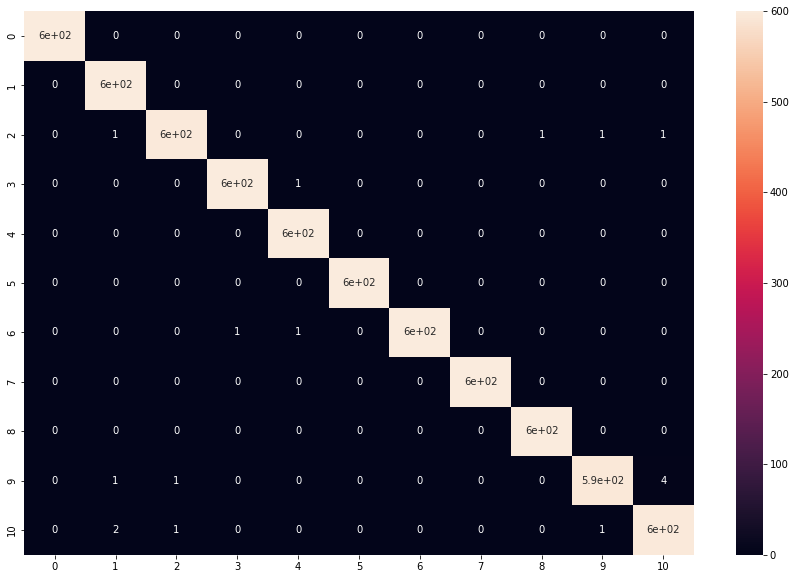

In [65]:
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot = True)
plt.show()

Visually, we can see that the model is very good. 

# Predicting unseen data

We kept the unseen data aside. We will now predict on the unseen data. Then we will create a submission file and submit that on Kaggle. 

In [66]:
submission_df = pd.read_csv('sample_submission.csv')
submission_df

,index,lang_id
0,1,tsn
1,2,nbl


In [67]:
test_df.head()

,index,text
0,1,mmasepala fa maemo a a kgethegileng a letlelel...
1,2,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,tshivhumbeo tshi fana na ngano dza vhathu
3,4,kube inja nelikati betingevakala kutsi titsini...
4,5,winste op buitelandse valuta


We'll transform the text column in the unseen text data first. 

In [68]:
unseen = tfidf.transform(test_df['text']).toarray()

In [69]:
# then make prediction on the unseen 
lang = clf.predict(unseen)

In [70]:
# we will then transform the numerics in the predictions to the initial language categorical labels
lang = le.inverse_transform(lang)

It's now time to create the data frame for Kaggle submission


In [71]:
# extracting the index column
index = test_df['index']
index

0          1
1          2
2          3
3          4
4          5
        ... 
5677    5678
5678    5679
5679    5680
5680    5681
5681    5682
Name: index, Length: 5682, dtype: int64

In [72]:
final_df = pd.DataFrame({'index': index, 'lang_id': lang})
final_df.head()

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr


Next we convert the data frame to a csv file for Kaggle submission

In [73]:
final_df.to_csv('multihyper_last.csv', index=False)

# References

1. Language detection using natural language processing: https://www.analyticsvidhya.com/blog/2021/03/language-detection-using-natural-language-processing/
2. Build language detection using NLP: https://www.youtube.com/watch?v=YB7XXDXIusg